In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plotspectrum(f,Sn):
    plt.figure(0)
    plt.plot(f,np.abs(Sn),linewidth=3,color='b')
    plt.xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    plt.ylabel('Normalized $S_n$ amplitude', fontsize = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.figure(1)
    plt.plot(f,np.angle(Sn),linewidth=3,color='r')
    plt.xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    plt.ylabel('Normalized $S_n$ phase', fontsize = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

def plotspectrum2(f,Sn):
    fig, ax = plt.subplots()
    ax.plot(f,np.real(Sn),linewidth=1,color='b')
    ax.plot(f,np.imag(Sn),linewidth=1,color='r')
    ax.set_xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    ax.set_ylabel('$(S_n)$', fontsize = 10)

def plotspectrum3(f, Sn, Sn_fd):
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(f,np.real(Sn),linewidth=1,color='b', marker='o', linestyle='-', markersize=4,markerfacecolor='none',label= 'Re($S2^{exp}$)')
    ax.plot(f,np.imag(Sn),linewidth=1,color='r',  marker='o', linestyle='-', markersize=4,markerfacecolor='none', label= 'Im($S2^{exp}$)')
    ax.plot(f,np.real(Sn_fd),linewidth=1,color='b', label= 'Re($S2^{FDM}$)')
    ax.plot(f,np.imag(Sn_fd),linewidth=1,color='r', label= 'Im($S2^{FDM}$)')
    ax.set_xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    ax.set_ylabel('$(S_n)$', fontsize = 10)
    ax.legend()

def readmaterial(f, filename):
    material = np.genfromtxt(filename, delimiter=',')
    material = np.flipud(material)
    fp = material[:,0]
    eps = np.interp(f, fp, material[:,1]) + 1j*np.interp(f, fp, material[:,2])
    return eps

def readmaterial2(f, filename1, filename2):
    material1 = np.genfromtxt(filename1, delimiter=',')
    f1 = material1[:,0]
    eps1 = np.interp(f,f1, material1[:,1])
    material2 = np.genfromtxt(filename2, delimiter=',')
    f2 = material2[:,0]
    eps2 = np.interp(f,f2,material2[:,1])
    eps = eps1+1j*eps2
    return eps

def finitedipole(w,z,eps,a,L,g):
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    for i in range(len(z)):
        alpha_eff[:,i]=beta*(g-(a+z[i]/L)*np.log(4*L/(4*z[i]+3*a)))/(np.log(4*L/a)-beta*(g-(3*a+4*z[i])/(4*L))*np.log(2*L/(2*z[i]+a)))
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff

def finitedipole_2(w,z,eps,a,L,g):
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    W_0 = z + 1.31*a
    W_1 = z + a/2
    for j in range(len(w)):
        for i in range(len(z)):
            f_0 = (g-(a+z[i]+W_0[i])/(2*L))*np.log(4*L/(a+2*z[i]+2*W_0[i]))/np.log(4*L/a)
            f_1 = (g-(a+z[i]+W_1[i])/(2*L))*np.log(4*L/(a+2*z[i]+2*W_1[i]))/np.log(4*L/a)
            alpha_eff[j,i] = beta[j]*f_0/(1-beta[j]*f_1)
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff

def pointdipole(w,z,eps,a):
    z = z+a
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    alpha = 4*math.pi*a**3
    for j in range(len(w)):
        for i in range(len(z)):
            alpha_eff[j,i] = alpha/(1-alpha*beta[j]/(16*math.pi*z[i]**3))
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff
    
def demodulate(alpha_eff,t,n):
    fourier=np.cos(n*t)
    fourier=np.repeat(fourier[:,np.newaxis],len(alpha_eff[1,:]),1)
    Sn=np.trapz(alpha_eff*fourier,axis=0)
    return Sn

def lorentzeps(w,w0,s,gamma,eps_inf):
    eps=eps_inf+s/(w0**2-w**2-1j*w*gamma)
    return eps

def Sn(w,eps,z,a,L,g,t,n):
    s_samp=demodulate(finitedipole(w,z,eps,a,L,g),t,n)
    s_ref=demodulate(finitedipole(w,z,-10000+10000j,a,L,g),t,n)
    sn=s_samp/s_ref
    return sn

def Sn_2(w,eps,z,a,L,g,t,n):
    s_samp=demodulate(finitedipole_2(w,z,eps,a,L,g),t,n)
    eps_ref = np.ones(1)*(-10000+10000*1j)
    s_ref=demodulate(finitedipole_2([1],z,eps_ref,a,L,g),t,n)
    sn=s_samp/s_ref
    return sn

def Sn_3(w,eps,z,a,t,n):
    s_samp=demodulate(pointdipole(w,z,eps,a),t,n)
    eps_ref = np.ones(1)*(11.7)
    s_ref=demodulate(pointdipole([1],z,eps_ref,a),t,n)
    sn=s_samp/s_ref
    return sn

def farfieldfactor(f,eps):
    import math
    n0 = np.ones(len(f))
    #n1 = np.sqrt(eps)
    n1 = np.sqrt((0.5*np.sqrt(eps*np.conj(eps))+np.real(eps)/2)) + np.sqrt((0.5*np.sqrt(eps*np.conj(eps))-np.real(eps)/2))*1j
    theta = math.pi/3
    cos_theta_t = np.sqrt(1-(n0*np.sin(theta)/n1)**2)
    r = (-n0*cos_theta_t + n1*np.cos(theta))/(n0*cos_theta_t + n1*np.cos(theta))
    FFF = (1+r)*(1+r)
    return FFF

def nk_to_eps(n,k):
    eps1 = n**2-k**2
    eps2 = 2*n*k
    return eps1, eps2


In [28]:
main_data_dict = dict()


In [29]:
data = np.genfromtxt(r'C:\nano_optics_ml_data\raw\Au_nk.csv', delimiter = ',')
f = data[:,0]
f_Au = np.linspace(1000, 1200,500)
n = np.interp(f_Au, f, data[:,1])
k = np.interp(f_Au, f, data[:,2])
eps1, eps2 = nk_to_eps(n,k)
eps_Au = eps1 + 1j*eps2


C:\Users\leona\AppData\Local\Temp\ipykernel_17800\1525320329.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Sn=np.trapz(alpha_eff*fourier,axis=0)


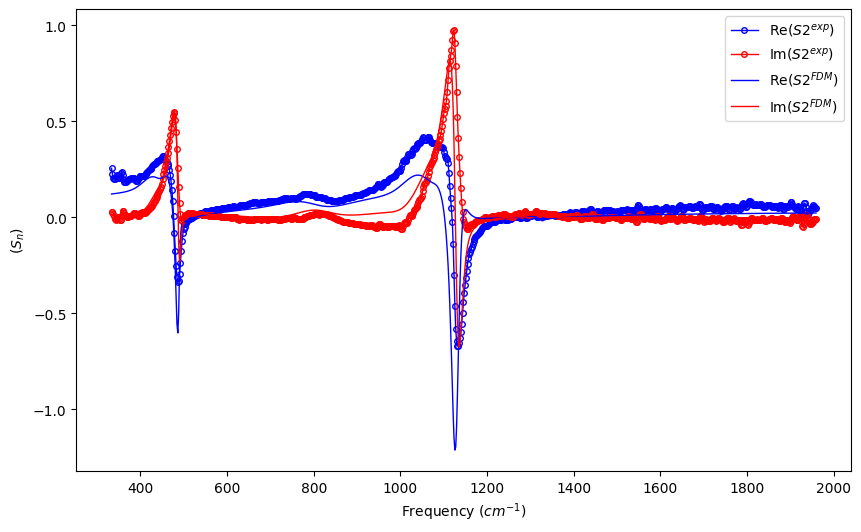

In [30]:
t = np.linspace(0, math.pi,30)
A = 68
h0 = 0
a = 50
L = 500
z = A - A*np.cos(t) + h0
n = 2
g = 0.7*np.exp(0.07*1j)
SiO2 = np.genfromtxt(r'C:\nano_optics_ml_data\raw\SiO2_eff.csv',delimiter=',')
eps_SiO2 = SiO2[:,0] + 1j*SiO2[:,1]
Sn_SiO2 = SiO2[:,2] + 1j*SiO2[:,3]
f_SiO2 = SiO2[:,4]
Sn_SiO2_cal_fd = 0.25*farfieldfactor(f_SiO2,eps_SiO2)*Sn_2(f_SiO2,eps_SiO2,z,a,L,g,t,n)

SiO2_dict = dict()
SiO2_dict['eps1']  = eps_SiO2.real
SiO2_dict['eps2']  = eps_SiO2.imag
SiO2_dict['Sn_exp_real']  = Sn_SiO2.real
SiO2_dict['Sn_exp_imag']  = Sn_SiO2.imag
SiO2_dict['f']  = f_SiO2
SiO2_dict['Sn_fdm_real']  = Sn_SiO2_cal_fd.real
SiO2_dict['Sn_fdm_imag']  = Sn_SiO2_cal_fd.imag

main_data_dict['SiO2'] = SiO2_dict

plotspectrum3(f_SiO2,Sn_SiO2,  Sn_SiO2_cal_fd)



C:\Users\leona\AppData\Local\Temp\ipykernel_17800\1525320329.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Sn=np.trapz(alpha_eff*fourier,axis=0)


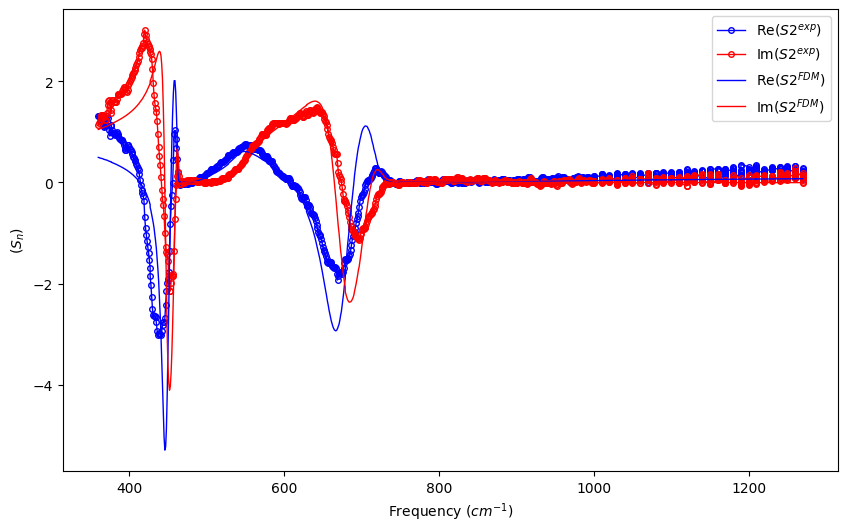

In [31]:
STO = np.genfromtxt(r'C:\nano_optics_ml_data\raw\STO_eff.csv',delimiter=',')
eps_STO = STO[:,0] + 1j*STO[:,1]
Sn_STO = STO[:,2] + 1j*STO[:,3]
f_STO = STO[:,4]
Sn_STO_cal_fd = 0.25*farfieldfactor(f_STO,eps_STO)*Sn_2(f_STO,eps_STO,z,a,L,g,t,n)

STO_dict = dict()
STO_dict['eps1']  = eps_STO.real
STO_dict['eps2']  = eps_STO.imag
STO_dict['Sn_exp_real']  = Sn_STO.real
STO_dict['Sn_exp_imag']  = Sn_STO.imag
STO_dict['f']  = f_STO
STO_dict['Sn_fdm_real']  = Sn_STO_cal_fd.real
STO_dict['Sn_fdm_imag']  = Sn_STO_cal_fd.imag

main_data_dict['STO'] = STO_dict

plotspectrum3(f_STO,Sn_STO,  Sn_STO_cal_fd)

C:\Users\leona\AppData\Local\Temp\ipykernel_17800\1525320329.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Sn=np.trapz(alpha_eff*fourier,axis=0)


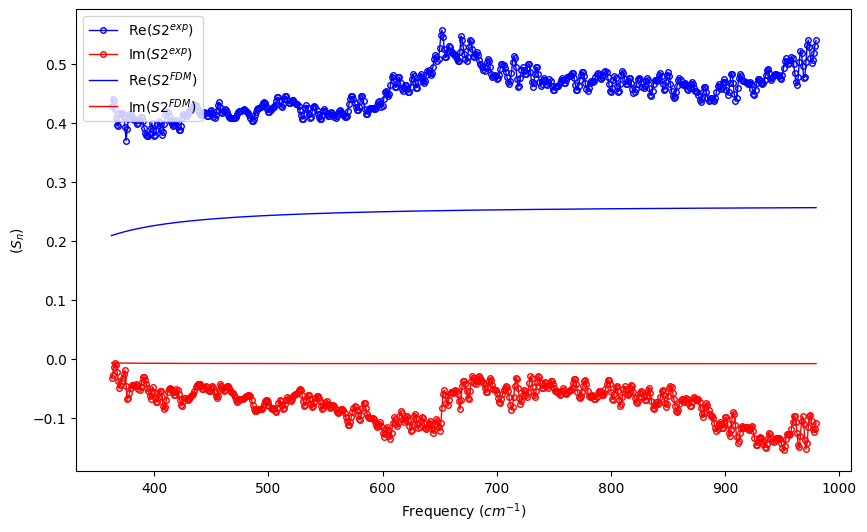

In [32]:
GaAs = np.genfromtxt(r'C:\nano_optics_ml_data\raw\GaAs_eff.csv',delimiter=',')
eps_GaAs = GaAs[:,0] + 1j*GaAs[:,1]
Sn_GaAs = GaAs[:,2] + 1j*GaAs[:,3]
f_GaAs = GaAs[:,4]
Sn_GaAs_cal_fd = 0.25*farfieldfactor(f_GaAs,eps_GaAs)*Sn_2(f_GaAs,eps_GaAs,z,a,L,g,t,n)

GaAs_dict = dict()
GaAs_dict['eps1']  = eps_GaAs.real
GaAs_dict['eps2']  = eps_GaAs.imag
GaAs_dict['Sn_exp_real']  = Sn_GaAs.real
GaAs_dict['Sn_exp_imag']  = Sn_GaAs.imag
GaAs_dict['f']  = f_GaAs
GaAs_dict['Sn_fdm_real']  = Sn_GaAs_cal_fd.real
GaAs_dict['Sn_fdm_imag']  = Sn_GaAs_cal_fd.imag

main_data_dict['GaAs'] = GaAs_dict

plotspectrum3(f_GaAs, Sn_GaAs, Sn_GaAs_cal_fd)

C:\Users\leona\AppData\Local\Temp\ipykernel_17800\1525320329.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Sn=np.trapz(alpha_eff*fourier,axis=0)


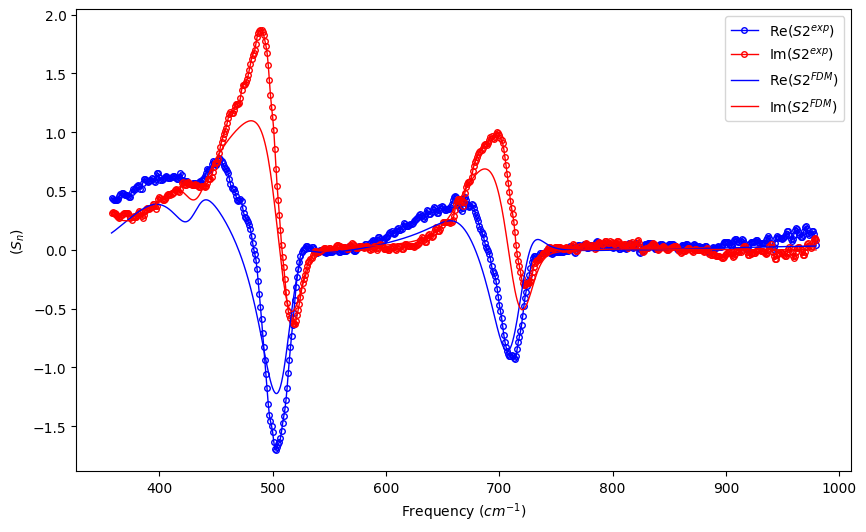

In [33]:

LSAT = np.genfromtxt(r'C:\nano_optics_ml_data\raw\LSAT_eff.csv',delimiter=',')
eps_LSAT = LSAT[:,0] + 1j*LSAT[:,1]
Sn_LSAT = LSAT[:,2] + 1j*LSAT[:,3]
f_LSAT = LSAT[:,4]
Sn_LSAT_cal_fd = 0.25*farfieldfactor(f_LSAT,eps_LSAT)*Sn_2(f_LSAT,eps_LSAT,z,a,L,g,t,n)

LSAT_dict = dict()
LSAT_dict['eps1']  = eps_LSAT.real
LSAT_dict['eps2']  = eps_LSAT.imag
LSAT_dict['Sn_exp_real']  = Sn_LSAT.real
LSAT_dict['Sn_exp_imag']  = Sn_LSAT.imag
LSAT_dict['f']  = f_LSAT
LSAT_dict['Sn_fdm_real']  = Sn_LSAT_cal_fd.real
LSAT_dict['Sn_fdm_imag']  = Sn_LSAT_cal_fd.imag

main_data_dict['LSAT'] = LSAT_dict
plotspectrum3(f_LSAT, Sn_LSAT, Sn_LSAT_cal_fd)

C:\Users\leona\AppData\Local\Temp\ipykernel_17800\1525320329.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Sn=np.trapz(alpha_eff*fourier,axis=0)


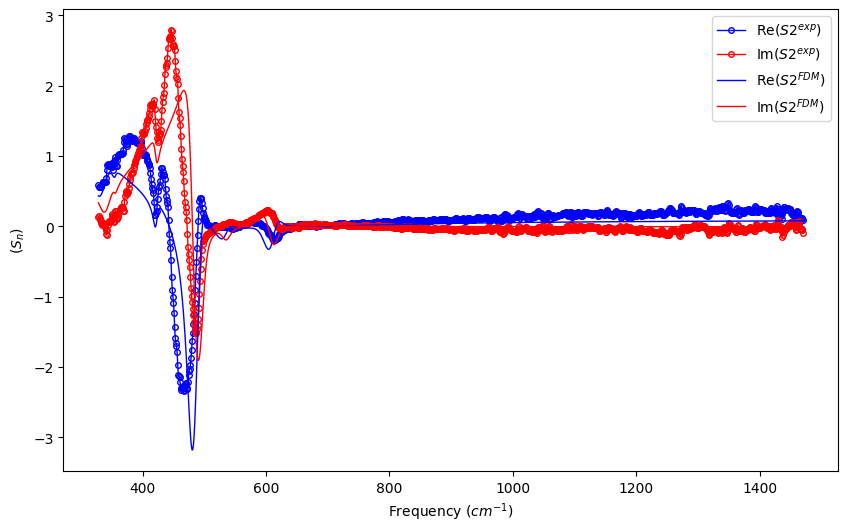

In [34]:
NGO = np.genfromtxt(r'C:\nano_optics_ml_data\raw\NGO_eff.csv',delimiter=',')
eps_NGO = NGO[:,0] + 1j*NGO[:,1]
Sn_NGO = NGO[:,2] + 1j*NGO[:,3]
f_NGO = NGO[:,4]
Sn_NGO_cal_fd = 0.25*farfieldfactor(f_NGO,eps_NGO)*Sn_2(f_NGO,eps_NGO,z,a,L,g,t,n)

NGO_dict = dict()
NGO_dict['eps1']  = eps_NGO.real
NGO_dict['eps2']  = eps_NGO.imag
NGO_dict['Sn_exp_real']  = Sn_NGO.real
NGO_dict['Sn_exp_imag']  = Sn_NGO.imag
NGO_dict['f']  = f_NGO
NGO_dict['Sn_fdm_real']  = Sn_NGO_cal_fd.real
NGO_dict['Sn_fdm_imag']  = Sn_NGO_cal_fd.imag

main_data_dict['NGO'] = NGO_dict
plotspectrum3(f_NGO, Sn_NGO, Sn_NGO_cal_fd)

C:\Users\leona\AppData\Local\Temp\ipykernel_17800\1525320329.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Sn=np.trapz(alpha_eff*fourier,axis=0)


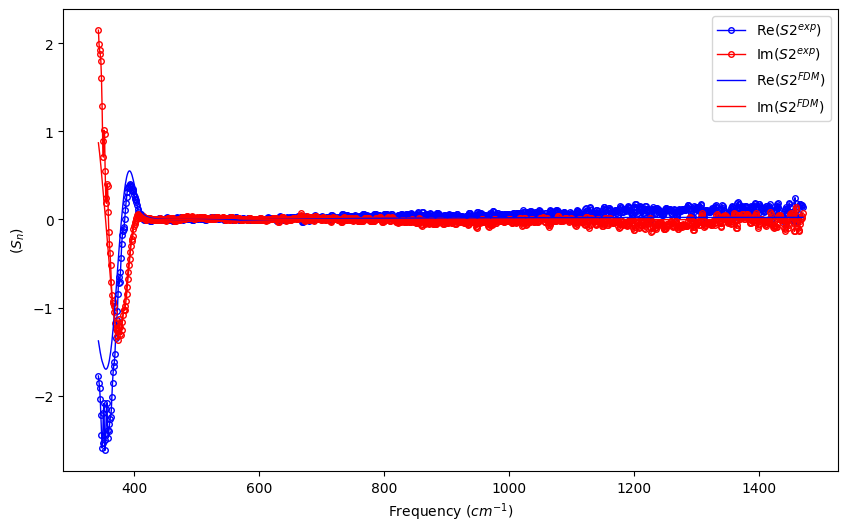

In [35]:

CaF2 = np.genfromtxt(r'C:\nano_optics_ml_data\raw\CaF2_eff.csv',delimiter=',')
data = np.genfromtxt(r'C:\nano_optics_ml_data\raw\CaF2_nk.csv', delimiter = ',')
f_CaF2 = CaF2[:,4]
f = data[:,0]
n_CaF2 = np.interp(f_CaF2, f, data[:,1])
k_CaF2 = np.interp(f_CaF2, f, data[:,2])
eps1, eps2 = nk_to_eps(n_CaF2,k_CaF2)
eps_CaF2 = eps1 + 1j*eps2
Sn_CaF2 = CaF2[:,2] + 1j*CaF2[:,3]
Sn_CaF2_cal_fd = 0.25*farfieldfactor(f_CaF2,eps_CaF2)*Sn_2(f_CaF2,eps_CaF2,z,a,L,g,t,n)

CaF2_dict = dict()
CaF2_dict['eps1']  = eps_CaF2.real
CaF2_dict['eps2']  = eps_CaF2.imag
CaF2_dict['Sn_exp_real']  = Sn_CaF2.real
CaF2_dict['Sn_exp_imag']  = Sn_CaF2.imag
CaF2_dict['f']  = f_CaF2
CaF2_dict['Sn_fdm_real']  = Sn_CaF2_cal_fd.real
CaF2_dict['Sn_fdm_imag']  = Sn_CaF2_cal_fd.imag

main_data_dict['CaF2'] = CaF2_dict

plotspectrum3(f_CaF2, Sn_CaF2, Sn_CaF2_cal_fd)


In [36]:
import pandas as pd

materials_list = ['STO', 'SiO2','NGO','CaF2', 'LSAT', 'GaAs']

df_list = []
for material, values in main_data_dict.items():
    
    for key in values:
        values[key] = values[key].flatten()  # Ensure all arrays are 1D
    df = pd.DataFrame(values)
    df['material'] = material
    if material == 'SiO2':
        df = (df[df['f'] < 1400])
    else:
        df = (df[df['f'] < 800])

    df_list.append(df)  

final_df = pd.concat(df_list, ignore_index=True)
final_df

,eps1,eps2,Sn_exp_real,Sn_exp_imag,f,Sn_fdm_real,Sn_fdm_imag,material
0,4.956780,0.647297,0.255885,0.027444,333.370908,0.121982,0.011299,SiO2
1,4.973697,0.657776,0.226498,0.029745,335.331913,0.122487,0.011562,SiO2
2,4.991207,0.668238,0.207103,0.019812,337.292918,0.123009,0.011822,SiO2
3,5.009361,0.678674,0.197882,0.005644,339.253924,0.123548,0.012079,SiO2
4,5.028215,0.689081,0.198552,-0.008394,341.214929,0.124107,0.012333,SiO2
...,...,...,...,...,...,...,...,...
2832,1.474810,0.017470,0.007120,0.005281,795.187665,0.013816,-0.001132,CaF2
2833,1.476573,0.017385,0.010149,-0.015904,796.168168,0.013866,-0.001139,CaF2
2834,1.478338,0.017300,0.025408,-0.029559,797.148671,0.013917,-0.001146,CaF2
2835,1.480103,0.017215,0.043401,-0.030443,798.129173,0.013967,-0.001154,CaF2


In [37]:
final_df.to_csv(r'C:\nano_optics_ml_data\processed\article_main_data.csv')